In [1]:
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import math
%matplotlib inline
tf.compat.v1.disable_eager_execution()

In [2]:
X = np.load('X.npy')
Y = np.load('Y.npy')

In [3]:
print("Feature Vector Size:{}".format(X.shape))

Feature Vector Size:(2062, 64, 64)


In [4]:
print("Classification Vector Size:{}".format(Y.shape))

Classification Vector Size:(2062, 10)


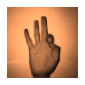

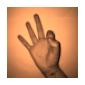

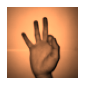

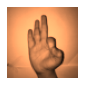

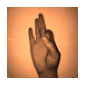

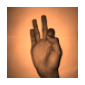

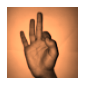

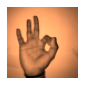

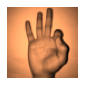

In [5]:
for i in range(1,10):
    plt.figure(figsize=(15,15))
    plt.subplot(1,10,i)
    plt.imshow(X[i],cmap='copper')
    plt.axis('off')

In [6]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33,random_state=0) 

In [7]:
X_train_flatten = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]).T
X_test_flatten = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]).T
Y_train = Y_train.T
Y_test = Y_test

In [8]:
X_train_flatten.shape

(4096, 1381)

In [9]:
Y_train.shape

(10, 1381)

In [10]:
X_test_flatten.shape

(4096, 681)

In [11]:
Y_test.shape

(681, 10)

In [12]:
def create_placeholders(n_x,n_y):
    X = tf.compat.v1.placeholder(tf.float32,[n_x,None],name='X')
    Y = tf.compat.v1.placeholder(tf.float32,[n_y,None],name='Y')
    return X,Y

In [13]:
def initialize_params():
    W1 = tf.compat.v1.get_variable("W1",[25,4096],initializer = tf.compat.v1.initializers.he_normal(seed=1))
    b1 = tf.compat.v1.get_variable("b1",[25,1],initializer=tf.zeros_initializer())
    W2 = tf.compat.v1.get_variable("W2",[15,25],initializer = tf.compat.v1.initializers.he_normal(seed=1))
    b2 = tf.compat.v1.get_variable("b2",[15,1],initializer=tf.zeros_initializer())
    W3 = tf.compat.v1.get_variable("W3",[10,15],initializer = tf.compat.v1.initializers.he_normal(seed=1))
    b3 = tf.compat.v1.get_variable("b3",[10,1],initializer=tf.zeros_initializer())
    parameters = {"W1": W1,"W2": W2,"W3": W3,"b1": b1,"b2": b2,"b3": b3}
    return parameters

In [14]:
def forward_prop(X,parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    return Z3

In [15]:
def comp_cost(Z3,Y,parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels)
    + 0.001*(tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)))
    return cost

In [16]:
def random_mini_batches(X, Y, mini_batch_size = 64,seed=0): 
    m = X.shape[1]
    mini_batches = []
    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [17]:
def nn(X_train,Y_train,X_test,Y_test,learning_rate=0.0001,
       num_epochs = 5000, minibatch_size = 64, print_cost = True):
    ops.reset_default_graph()
    seed=3
    (n_x,m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    X,Y = create_placeholders(n_x,n_y)
    parameters = initialize_params()
    Z3 = forward_prop(X,parameters)
    cost = comp_cost(Z3,Y,parameters)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.compat.v1.global_variables_initializer()
    with tf.compat.v1.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0
            num_minibatches = int(m/minibatch_size)
            seed = seed+1
            minibatches=random_mini_batches(X_train,Y_train,minibatch_size,seed)
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y) = minibatch
                _,minibatch_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                epoch_cost += minibatch_cost/minibatch_size
            if print_cost == True and epoch%100 == 0:
                print("Cost after epoch %i: %f"%(epoch,epoch_cost))
            if print_cost == True and epoch%5 == 0:
                costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.title("Learning Rate = " + str(learning_rate))
        plt.show()
        print("Parameters have been trained!!!")
        correct_prediction = tf.equal(tf.argmax(Z3),tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
        print("Train Accuracy",accuracy.eval({X:X_train,Y:Y_train}))
        print("Test Accuracy",accuracy.eval({X:X_test,Y:Y_test}))
        return parameters

Cost after epoch 0: 4.386311
Cost after epoch 100: 1.764058
Cost after epoch 200: 1.432292
Cost after epoch 300: 1.183166
Cost after epoch 400: 1.046788
Cost after epoch 500: 0.955825
Cost after epoch 600: 0.887332
Cost after epoch 700: 0.827783
Cost after epoch 800: 0.775989
Cost after epoch 900: 0.729624
Cost after epoch 1000: 0.685390
Cost after epoch 1100: 0.643086
Cost after epoch 1200: 0.603876
Cost after epoch 1300: 0.565256
Cost after epoch 1400: 0.526362
Cost after epoch 1500: 0.487441
Cost after epoch 1600: 0.448829
Cost after epoch 1700: 0.411997
Cost after epoch 1800: 0.370466
Cost after epoch 1900: 0.334187
Cost after epoch 2000: 0.296489
Cost after epoch 2100: 0.263471
Cost after epoch 2200: 0.232039
Cost after epoch 2300: 0.204505
Cost after epoch 2400: 0.180572
Cost after epoch 2500: 0.159729
Cost after epoch 2600: 0.141060
Cost after epoch 2700: 0.125968
Cost after epoch 2800: 0.111929
Cost after epoch 2900: 0.100609
Cost after epoch 3000: 0.091400
Cost after epoch 310

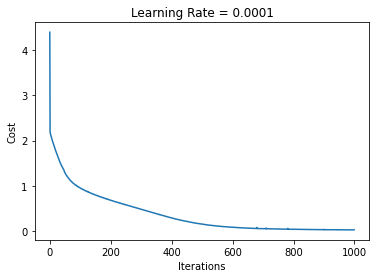

Parameters have been trained!!!
Train Accuracy 1.0
Test Accuracy 0.80763584


In [18]:
parameters = nn(X_train_flatten, Y_train, X_test_flatten, Y_test.T)

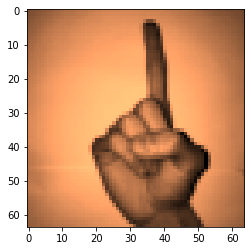

In [30]:
X_s_test = X_test[0]
Y_s_test = Y_test[0]
plt.imshow(X_s_test,cmap='copper')